# **streaming:**

Let's demonstrate how streaming works in graph state and events in LangGraph, allowing you to get real-time updates as each node processes information or generates output.

In [1]:
%%capture --no-stderr
%pip install -qU langgraph langchain-google-genai langchain_core langchain_community

In [2]:
# For Colab, use this:
from google.colab import userdata
GEMINI_API_KEY = userdata.get("GEMINI_API_KEY")

In [3]:
from langchain_google_genai import ChatGoogleGenerativeAI

gemini_flash: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(
    model='gemini-1.5-flash',
    temperature=0,
    api_key=GEMINI_API_KEY
)

In [4]:
from langgraph.graph import MessagesState
class State(MessagesState):
    summary: str

In [5]:
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langchain_core.runnables import RunnableConfig

def conversation(state: State, config: RunnableConfig):

    # Here, the function attempts to retrieve a summary from the state. If no summary exists, it defaults to an empty string ("").
    summary = state.get("summary", "")

    if summary:
        system_message = f"Summary of conversation earlier: {summary}"
        messages = [SystemMessage(content=system_message)] + state["messages"]
    else:
        messages = state["messages"]

    # If a summary exists, it creates a system_message that says, "Summary of conversation earlier: <summary content>".
    # This system_message is then added to the beginning of the conversation history (state["messages"]). This ensures that the model is provided with prior context.
    # If no summary exists, it simply passes the current messages without adding any additional context.

    response = gemini_flash.invoke(messages, config)
    return {"messages": response}
    # The function returns the response wrapped in a dictionary with the key "messages". This makes the function output compatible with other parts of the system that expect messages in the response.

In [6]:
def summarize_conversation(state: State):

    # retrieve any existing summary from the state. If a summary doesn’t exist yet, it defaults to an empty string ("").
    summary = state.get("summary", "")

    if summary:
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
    else:
        summary_message = "Create a summary of the conversation above:"
    # If a summary exists: It creates a prompt for extending the current summary with new information from the latest messages. The message template, This is the summary of the conversation to date: {summary}, provides the existing summary and instructs the model to extend it.
    # If no summary exists: It generates a prompt to create an initial summary with the message "Create a summary of the conversation above:".

    messages = state["messages"] + [HumanMessage(content=summary_message)]
    # This line adds the summary_message as a new HumanMessage to the conversation history (state["messages"]). This ensures the LLM can reference the recent conversation when generating a summary.

    response = gemini_flash.invoke(messages)

    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    # This creates a list of RemoveMessage objects for all but the last two messages in state["messages"].

    return {"summary": response.content, "messages": delete_messages}

In [7]:
from langgraph.graph import END

def should_continue(state: State):

    """Return the next node to execute."""

    messages = state["messages"]
    #The state["messages"] list contains all messages exchanged in the conversation up to this point.

    if len(messages) > 6:
        return "summarize_conversation"
    return END
    # If there are more than 6 messages in the conversation, it returns "summarize_conversation", instructing the workflow to proceed to a node that will summarize the conversation.
    # If the length of messages is 6 or fewer, the function returns END.
    # Returning END directs the workflow to terminate the conversation instead of continuing to a summarization step.

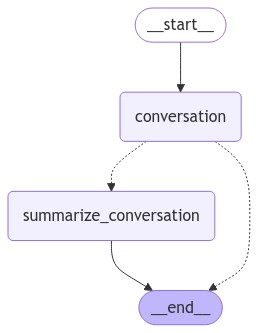

In [8]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.state import CompiledStateGraph

workflow = StateGraph(State)
workflow.add_node("conversation", conversation)
workflow.add_node("summarize_conversation", summarize_conversation)

workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

memory:MemorySaver = MemorySaver()
graph:CompiledStateGraph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

## **Concepts in Streaming Graph State:**

LangGraph provides two primary modes for streaming:

* **Streaming Updates (updates):** This streams only the changes or updates to the graph state after each node.

* **Streaming Full State (values)**: This streams the full graph state after each node is executed.

![values_vs_updates.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbaf892d24625a201744e5_streaming1.png)

## **Streaming State in updates Mode:**

In [9]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
for chunk in graph.stream({"messages": [HumanMessage(content="hi! I'm Ammar")]}, config, stream_mode="updates"):
    print(chunk)

{'conversation': {'messages': AIMessage(content='Hi Ammar! Nice to meet you. What can I do for you today? \n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-092eafab-735d-472b-aaa7-dcd765c23d7b-0', usage_metadata={'input_tokens': 8, 'output_tokens': 18, 'total_tokens': 26, 'input_token_details': {'cache_read': 0}})}}


Each chunk represents an update from one node in the graph. Here’s what each part of this code does:

* **stream method:** Runs the graph and streams results.

* **stream_mode="updates":** Streams only updates (differences) in the graph state, rather than the full state.

### **Printing Each Update:**

This loop displays only the updated part of the state after each node:

In [10]:
for chunk in graph.stream({"messages": [HumanMessage(content="hi! I'm Ammar")]}, config, stream_mode="updates"):
    chunk['conversation']["messages"].pretty_print()

================================== Ai Message ==================================

Hi Ammar! It's nice to meet you. What can I help you with today?


## **Streaming State in values Mode:**

In values mode, the full graph state is streamed after each node completes, showing cumulative information:

In [11]:
# Start conversation, again
config = {"configurable": {"thread_id": "2"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Ammar")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    for m in event['messages']:
        m.pretty_print()
    print("---"*25)

================================ Human Message =================================

hi! I'm Ammar
---------------------------------------------------------------------------
================================ Human Message =================================

hi! I'm Ammar
================================== Ai Message ==================================

Hi Ammar! It's nice to meet you. What can I do for you today?
---------------------------------------------------------------------------


* **stream_mode="values":** Streams the complete graph state, so each node’s result includes all previous information.

* **Looping through event['messages']:** This displays all messages, not just updates, after each node executes.

## **Example Scenario: Chatbot with Two Nodes:**

Imagine a chatbot graph with two nodes:

* **Greet Node:** The chatbot greets the user based on their name.

* **Question Node:** The chatbot asks the user a question based on their interests.

For simplicity, we’ll assume this graph processes a state object with name and interests keys. The graph.invoke() method runs through each node sequentially.

* **Initial State:** { "name": "Ammar", "interests": "football" }

**Code Example for updates Mode:**
```
config = {"configurable": {"thread_id": "1"}}
initial_state = {"name": "Ammar", "interests": "football"}

# Start streaming in `updates` mode
for update in graph.stream(initial_state, config, stream_mode="updates"):
    print("Update from the latest node:", update)
```

**Output for updates Mode:**

After Greet Node (Greet Node only adds a greeting message):
```
{
    "greeting": "Hello, Ammar!"
}
```

After Question Node (Question Node only adds a question message):
```
{
    "question": "Do you like watching football games?"
}
```

In updates mode, each step only shows the changes (or updates) that each node contributed to the state. Unlike values mode, you don’t see the full state here, only what’s newly added or modified by each node.

**Code Example for values Mode:**



```
config = {"configurable": {"thread_id": "1"}}
initial_state = {"name": "Ammar", "interests": "football"}

# Start streaming in `values` mode
for event in graph.stream(initial_state, config, stream_mode="values"):
    print("Current full state after node execution:", event)
```



**Output for values Mode:**

After Greet Node (Greet Node greets based on name):
```
{
    "name": "Ammar",
    "interests": "football",
    "greeting": "Hello, Ammar!"
}
```

After Question Node (Question Node asks about interests):
```
{
    "name": "Ammar",
    "interests": "football",
    "greeting": "Hello, Ammar!",
    "question": "Do you like watching football games?"
}
```


In values mode, each step shows the complete graph state after each node is processed. You can see how the state builds up as each node adds to it.

## **Streaming Tokens:** (need to make it work using Gemini. Currently not working)

In the above examples we saw how we can stream the state of our graph.

However, it is also very common to stream the chat model calls (tokens) as they are generated.

For streaming tokens generated by a chat model, you can use .astream_events, which captures events in real time as they’re generated:

In [12]:
config = {"configurable": {"thread_id": "3"}}
input_message = HumanMessage(content="Tell me about the Real Madrid team")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
  print(f"Node: {event['metadata'].get('langgraph_node','')}. Type: {event['event']}. Name: {event['name']}")

Node: . Type: on_chain_start. Name: LangGraph
Node: __start__. Type: on_chain_start. Name: __start__
Node: __start__. Type: on_chain_end. Name: __start__
Node: conversation. Type: on_chain_start. Name: conversation
Node: conversation. Type: on_chat_model_start. Name: ChatGoogleGenerativeAI
Node: conversation. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversati

**astream_events method:** Asynchronous method that streams events as they are emitted within nodes.

**Event Details:** Each event dictionary contains:
* **event:** Type of event (e.g., on_chat_model_stream for token streaming).

* **metadata:** Metadata, such as langgraph_node, indicating which node emitted the event.



The central point is that tokens from chat models within your graph have the on_chat_model_stream type.

We can use event['metadata']['langgraph_node'] to select the node to stream from.

And we can use event['data'] to get the actual data for each event, which in this case is an AIMessageChunk.

In [13]:
node_to_stream = 'conversation'
config = {"configurable": {"thread_id": "3"}}
input_message = HumanMessage(content="Tell me about the Real Madrid team")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens from a particular node
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        print(event["data"])

{'chunk': AIMessageChunk(content='Real Madrid is a', additional_kwargs={}, response_metadata={'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-73b95112-35ca-459f-a5f3-d4ec389d20ea', usage_metadata={'input_tokens': 601, 'output_tokens': 4, 'total_tokens': 605, 'input_token_details': {'cache_read': 0}})}
{'chunk': AIMessageChunk(content=" footballing giant, a club steeped in history and renowned for its success. Here'", additional_kwargs={}, response_metadata={'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 

As you see above, just use the chunk key to get the AIMessageChunk.

In [14]:
config = {"configurable": {"thread_id": "3"}}
input_message = HumanMessage(content="Tell me about the Real Madrid team")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens from a particular node
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        data = event["data"]
        print(data["chunk"].content, end="|")

Real Madrid is| more than just a football club; it's a global phenomenon, a symbol of success,| and a source of endless passion for millions of fans worldwide. Here's a glimpse into| what makes them so special:

**A Legacy of Success:**

* **Founded in 1902:** Real Madrid boasts a rich history, dating back| over a century. They've been a dominant force in Spanish and European football, consistently challenging for top honors.
* **Royal Recognition:** The "Real" in their| name was bestowed by King Alfonso XIII in 1920, signifying their royal patronage and adding to their prestige.
* **La Decima and Beyond:** Their 10th Champions League title in 2014, after| a 12-year drought, marked a new era of dominance. Since then, they've added another four titles, solidifying their position as the most successful club in Champions League history.

**A Star-Studded Roster:**

*| **Karim Benzema:** A Ballon d'Or winner and a true legend, Benzema is a prolific striker known for his clinical finishing,